<a href="https://colab.research.google.com/github/GdMacmillan/ml_flux_tutorial/blob/master/ML_Flux_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML/FLux Tutorial

by Gordon MacMillan

## 1. Setting up environment

This environment is meant to be used in Google Colaboratory so that the user can take advantage of Google cloud hardware accelerators. A Python 3 environment is the default for Colab notebooks, but a hack can be used to install and run a Julia Kernel. The below code will download and install dependencies so that this hack can be applied. Please execute the following cell and reload the page (Ctrl-r) to setup the environment.

In [0]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget http://developer.download.nvidia.com/compute/cuda/10.1/Prod/local_installers/cuda-repo-ubuntu1804-10-1-local-10.1.243-418.87.00_1.0-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu1804-10-1-local-10.1.243-418.87.00_1.0-1_amd64.deb
!sudo apt-key add /var/cuda-repo-10-1-local-10.1.243-418.87.00/7fa2af80.pub
!sudo apt-get update
!sudo apt-get -y install cuda-10-1 gcc-6 g++-6 -y -q
!ln -s /usr/bin/gcc-6 /usr/local/cuda/bin/gcc
!ln -s /usr/bin/g++-6 /usr/local/cuda/bin/g++

!curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.0-linux-x86_64.tar.gz" -o julia.tar.gz
!tar -xzf julia.tar.gz -C /usr --strip-components 1
!rm -rf julia.tar.gz*
!julia -e 'using Pkg; pkg"add IJulia; add CuArrays; add CUDAnative; add CUDAdrv; add Flux; add BenchmarkTools; add MLDatasets; add ImageMagick; add ImageCore; add Plots; precompile"'

--2020-01-23 14:09:27--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 192.229.211.70, 2606:2800:233:ef6:15dd:1ece:1d50:1e1
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|192.229.211.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56 [application/octet-stream]
Saving to: ‘cuda-ubuntu1804.pin’

cuda-ubuntu1804.pin 100%[===================>]      56  --.-KB/s    in 0s      

2020-01-23 14:09:27 (3.00 MB/s) - ‘cuda-ubuntu1804.pin’ saved [56/56]

--2020-01-23 14:09:31--  http://developer.download.nvidia.com/compute/cuda/10.1/Prod/local_installers/cuda-repo-ubuntu1804-10-1-local-10.1.243-418.87.00_1.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 192.229.211.70, 2606:2800:233:ef6:15dd:1ece:1d50:1e1
Connecting to developer.download.nvidia.com (developer.download.nvidia.com

*** Ctrl-r to refresh page ***

Now the Julia environment should be ready to go. First, lets test to make sure the GPU is being utilized. You need to have CUDA available to use CuArrays.

### Set up some Cuda arrays and test for GPU

In [0]:
using CuArrays

┌ Warning: You are using CUDNN 7.6.5 for CUDA 10.1.0 with CUDA toolkit 10.0.145; these might be incompatible.
└ @ CuArrays /root/.julia/packages/CuArrays/1njKF/src/CuArrays.jl:122


In [0]:
W = cu(rand(2, 5)) # a 2×5 CuArray
b = cu(rand(2))

predict(x) = W*x .+ b
loss(x, y) = sum((predict(x) .- y).^2)

x, y = cu(rand(5)), cu(rand(2)) # Dummy data
loss(x, y) # ~ 3

0.4684248f0

In [0]:
using CUDAnative

In [0]:
function say(num)
    """print number using cuda threads"""
    @cuprintf("Thread %ld says: %ld\n",
              threadIdx().x, num)
    return
end

say (generic function with 1 method)

In [0]:
@cuda threads=8 say(42)

Better example: Apply function to array

In [0]:
a = CuArray([1., 2., 3.])
b = CuArray([3., -3., 6.])

function diff_sq(a, b)
    f = (x, y) -> (x - y)^2
    i = threadIdx().x
    a[i] = f(a[i], b[i])
    return 
end

norm = x -> sqrt(sum(x))

@cuda threads = length(a) diff_sq(a, b)
norm(a)

6.164414002968976

In [0]:
f(x, y) = sum((x .- y).^2) |> gpu
# TODO: check if faster than the above

f (generic function with 1 method)

In [0]:
using CUDAdrv
CUDAdrv.name(CuDevice(0))

"Tesla P100-PCIE-16GB"

In [0]:
using Flux: Conv, gpu
using BenchmarkTools

### Benchmark image convolution test

In [0]:
random_image_cpu = randn(100, 100, 3, 100)
random_image_gpu = cu(randn(100, 100, 3, 100))

m = Conv((7, 7), 3 => 64)

println("""Time (s) to convolve 7x7x3 filter over random 100x100x3x100 images
        (width x height x channel x batch).""")
println("CPU (s):")
@btime m(random_image_cpu);

m = Conv((7, 7), 3 => 3) |> gpu

println("GPU (s):")
@btime m(random_image_gpu);

Time (s) to convolve 7x7x3 filter over random 100x100x3x100 images
(width x height x channel x batch).
CPU (s):
  12.576 s (42 allocations: 862.89 MiB)
GPU (s):
  72.155 μs (249 allocations: 11.00 KiB)


TODO: Perform a benchmark of julia wrapper for tensorflow:  [TensorFlow.jl](https://github.com/malmaud/TensorFlow.jl)

## 2. Use Case: Fashion MNIST


In [0]:
using MLDatasets
FashionMNIST.download(i_accept_the_terms_of_use=true)

# load full training set
train_x, train_y = FashionMNIST.traindata();

# load full test set
test_x,  test_y  = FashionMNIST.testdata();

┌ Info: Downloading
│   source = http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
│   dest = /root/.julia/datadeps/FashionMNIST/train-labels-idx1-ubyte.gz
│   progress = 1.0
│   time_taken = 0.04 s
│   time_remaining = 0.0 s
│   average_speed = 720.581 KiB/s
│   downloaded = 28.823 KiB
│   remaining = 0 bytes
│   total = 28.823 KiB
└ @ HTTP /root/.julia/packages/HTTP/lZVI1/src/download.jl:119
┌ Info: Downloading
│   source = http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
│   dest = /root/.julia/datadeps/FashionMNIST/t10k-labels-idx1-ubyte.gz
│   progress = 1.0
│   time_taken = 0.0 s
│   time_remaining = 0.0 s
│   average_speed = 4.910 MiB/s
│   downloaded = 5.027 KiB
│   remaining = 0 bytes
│   total = 5.027 KiB
└ @ HTTP /root/.julia/packages/HTTP/lZVI1/src/download.jl:119
┌ Info: Downloading
│   source = http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
│   dest = /root/.julia

In [0]:
using ImageCore
FashionMNIST.convert2image(FashionMNIST.traintensor(4))

In [0]:
@doc(FashionMNIST.convert2image) # same as `? FashionMNIST.convert2image`

```
convert2image(array) -> Array{Gray}
```

Convert the given MNIST horizontal-major tensor (or feature matrix) to a vertical-major `Colorant` array. The values are also color corrected according to the website's description, which means that the digits are black on a white background.

```julia
julia> MNIST.convert2image(MNIST.traintensor()) # full training dataset
28×28×60000 Array{Gray{N0f8},3}:
[...]

julia> MNIST.convert2image(MNIST.traintensor(1)) # first training image
28×28 Array{Gray{N0f8},2}:
[...]
```


In [0]:
using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle, params
using Statistics: mean
using Base.Iterators: partition
using Random
Random.seed!(32)

MersenneTwister(UInt32[0x00000020], Random.DSFMT.DSFMT_state(Int32[362167519, 1073538041, 791601329, 1072922344, -1200180471, 1073405548, 802389604, 1073721749, 1597631051, 1072866084  …  -752455786, 1072947302, -470736313, 1073186836, -1839481848, -1674302192, 1144353388, 772375038, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000

In [0]:
@info("Constructing MLP model...")
model() = Chain(
  Conv((5, 5), 1 => 64, elu, pad=(2, 2), stride=(1, 1)),
  BatchNorm(64),
  MaxPool((3, 3), pad=(2, 2), stride=(2, 2)),
  Dropout(0.25),
  Conv((5, 5), 64 => 128, elu, pad=(2, 2), stride=(1, 1)),
  BatchNorm(128),
  MaxPool((2, 2), stride=(2, 2)),
  Dropout(0.25),
  Conv((5, 5), 128 => 256, elu, pad=(2, 2), stride=(1, 1)),
  BatchNorm(256),
  MaxPool((2, 2), stride=(2, 2)),
  Dropout(0.25),
  x -> reshape(x, :, size(x, 4)),
  Dense(2304, 256, elu),
  Dropout(0.5),
  Dense(256, 10),
  softmax) |> gpu

┌ Info: Constructing MLP model...
└ @ Main In[15]:1


model (generic function with 1 method)

In [0]:
N = size(train_x)[end]
# random permute train indexes
ixs = collect(1:N)
shuffle!(ixs)
n = Int(floor(.9 * N))
# batch size
bs = 100
sz = (28, 28, 1, bs)

# 90/10 hold out split
train_split, val_split = ixs[1:n], ixs[n + 1:end]

train_data = train_x[:, :, train_split], train_y[train_split]
val_data = train_x[:, :, val_split], train_y[val_split]
test_data = test_x, test_y

```
Make batches of x, y data

returns: list of tuples
```
function make_batches(data; bs=100)
    n = size(data[1])[end]
    sz = (28, 28, 1, bs)
    iter = [(reshape(Float32.(data[1][:, :, i]), sz), onehotbatch(data[2][i], 0:9)) for i in partition(1:n, bs)] |> gpu
end

train = make_batches(train_data)
val = make_batches(val_data)
test = make_batches(test_data);

### Testing the forward pass on a single image

In [0]:
m = model()

Chain(Conv((5, 5), 1=>64, elu), BatchNorm(64), MaxPool((3, 3), pad = (2, 2), stride = (2, 2)), Dropout(0.25), Conv((5, 5), 64=>128, elu), BatchNorm(128), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Dropout(0.25), Conv((5, 5), 128=>256, elu), BatchNorm(256), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Dropout(0.25), #9, Dense(2304, 256, elu), Dropout(0.5), Dense(256, 10), softmax)

In [0]:
img = reshape(train[1][1][:, :, :, 1], (28, 28, 1, 1))
# img = reshape(val[1][1][:, :, :, 1], (28, 28, 1, 1))

28×28×1×1 CuArray{Float32,4,CuArray{Float32,3,Nothing}}:
[:, :, 1, 1] =
 0.0         0.0         0.0         …  0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0         …  0.0         0.0       0.0      
 0.0         0.0         0.00392157     0.0         0.0       0.0      
 0.0         0.0         0.0            0.0         0.0       0.0      
 0.0         0.0         0.0196078      0.0         0.0       0.0      
 0.0         0.0         0.435294       0.301961    0.266667  0.0784314
 0.0         0.133333    0.384314    …  0.364706    0.435294  0.313726 
 0.0         0.321569    0.309804       0.14902     0.298039  0.341176 
 0.0         0.266667    0.337255       0.584314    0.631373  0.

In [0]:
m(img)

10×1 CuArray{Float32,2,Nothing}:
 0.10063214 
 0.09824421 
 0.10722762 
 0.09882989 
 0.09707087 
 0.0917206  
 0.100451134
 0.09807167 
 0.10925116 
 0.09850067 

### Train on loss function for one Epoch

Submitting a callback function can be used to interupt the execution of a training loop after each batch to compute test statistics.



In [0]:
eval_acc = []
batch_idx = 0

```
Defines accuracy metric to compute on data set
Pushes computed value to eval_acc array
Increments the batch index
```
function calc_metrics(data)
    global batch_idx
    acc = 0
    for batch in data
        x, y = batch
        pred = m(x) .> 0.5
        tp = Float32(sum((pred .+ y) .== Int16(2)))
        fp = Float32(sum((pred .- y) .== Int16(1)))
        fn = Float32(sum((pred .- y) .== Int16(-1)))
        tn = Float32(sum((pred .+ y) .== Int16(0)))
        acc += (tp + tn) / (tp + tn + fp + fn)
    end
    acc /= length(data)
    push!(eval_acc, acc)
    if batch_idx % 100 == 0
        @show(batch_idx)
    end
    
    batch_idx += 1
end

# Define the loss, callback and optimizer
loss(x, y) = crossentropy(m(x), y)
evalcb = () -> calc_metrics(val)
opt = ADAM()

# Start model training
Flux.train!(loss, params(m), train, opt, cb = evalcb)

batch_idx = 0
batch_idx = 100
batch_idx = 200
batch_idx = 300
batch_idx = 400
batch_idx = 500


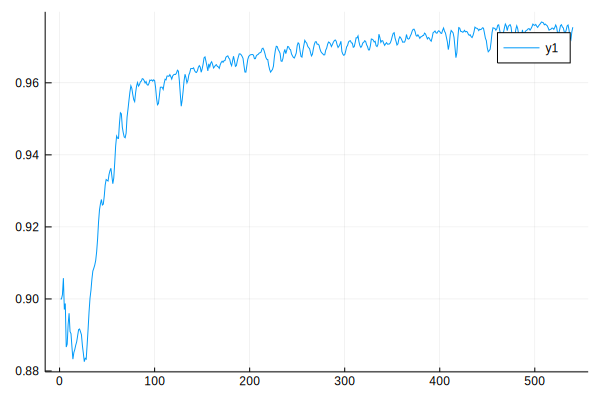

In [0]:
using Plots
x = 1:length(train); y = eval_acc;
plot(x,y)

### Check the results (inference)

Now that training is complete, let's see how well the model can predict on the test set...

In [0]:
eval_acc = [] # need to reset to calc test accuracy. this could be done better
calc_metrics(test)
println("accuracy on test data: ", eval_acc[1])

accuracy on test data: 0.9745399
